# Problemas de clasificacion.

## Librerias


In [6]:
# Importamos las librerías que vamos a necesitar
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

## Simulacion

Primero se generamos 10 medias mk a partir de una distribución
normal bivariada $N((1, 0)^{T}, \mathbb{I})$ y la etiquetamos **AZUL**.
Similarmente, otras 10 fueron generadas a partir de $N((0, 1)^{T}, \mathbb{I})$ y etiquetadas
como **NARANJA**.

In [7]:
# Definimos la media y la covarianza
mean = np.array([1, 0])
cov = np.eye(2)  # matriz de identidad de 2x2 para la covarianza

# Generamos los datos
medias_azul = np.random.multivariate_normal(mean, cov, 10)
print("Medias Azul:\n", medias_azul)

mean = np.array([0, 1])
medias_naranja = np.random.multivariate_normal(mean, cov, 10)
print("Medias Naranja:\n", medias_naranja)

Medias Azul:
 [[ 0.89280552 -0.48621729]
 [ 2.59298179 -0.4339416 ]
 [ 0.2673078  -0.57827691]
 [ 0.86428262 -0.79350502]
 [ 0.63155001  0.15720186]
 [ 0.88452659  0.83170858]
 [ 0.68064492 -0.20461651]
 [ 1.27106175  2.24480661]
 [ 0.21239809  1.92362441]
 [-0.18357317  0.22897043]]
Medias Naranja:
 [[-3.39386293e-01  1.84729063e-01]
 [ 6.99092382e-01  1.59989663e+00]
 [-4.81248134e-01 -1.09379400e+00]
 [-4.20047465e-01  1.13920411e+00]
 [ 1.81361119e-03  1.75593528e+00]
 [ 1.93354263e+00  1.41387484e+00]
 [ 5.67768368e-01  1.14818173e+00]
 [ 1.17243578e+00  1.53140001e+00]
 [ 7.49105677e-01  2.80895683e+00]
 [ 2.26984301e-01  7.29037738e-01]]


Luego, en cada clase generamos 100 observaciones a partir de una mezcla
de normales: para cada observación elegimos una media $m_{k}$ al azar
(con probabilidad 1/10), a partir de ello, el punto generado tendrá la distribución $ \mathcal{N} (m_k , \mathbb{I}/{5}).$

In [8]:
def gen_data(n, medias, seed=42):
    np.random.seed(seed)
    x, y = [], []
    for _ in range(n):
        mk = medias[np.random.choice(medias.shape[0])]
        x.append(np.random.normal(mk[0], 1 / np.sqrt(5)))
        y.append(np.random.normal(mk[1], 1 / np.sqrt(5)))
    return pd.DataFrame({"x": x, "y": y})


# Ejemplo de uso:
# datos = gen_data(100, medias_azul)

### Generacion de datos
Para la generación de datos vamos a guardar todo en único Dataframe que nos va a permitir graficar y analizar a posterior de manera más sencilla. Además vamos a codificar los colores de la siguiente forma:

\begin{align}
  \left\{\begin{array}{lcl}
    \text{label}(\text{Azul})&=&0\\
    \text{label}(\text{Naranja})&=&1\\
  \end{array}\right.
\end{align}

In [9]:
n_samples = 200

# Generamos los datos para cada clase
data_azul = pd.concat(
    [pd.Series([0] * (n_samples // 2)), gen_data(n_samples // 2, medias_azul)], axis=1
)
data_naranja = pd.concat(
    [pd.Series([1] * (n_samples // 2)), gen_data(n_samples // 2, medias_naranja)],
    axis=1,
)

# Unimos los datos y establecemos los nombres de las columnas
data = pd.concat([data_azul, data_naranja])
data.columns = ["label", "x", "y"]

print(data.shape)

(200, 3)


Con estos datos generados vamos a visualizar los mismos en un scatter plot

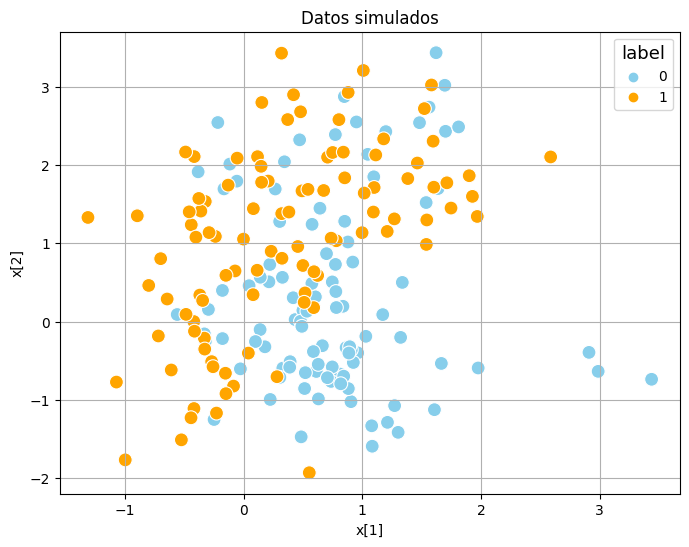

In [10]:
# Definimos los colores para las clases
palette = {0: "skyblue", 1: "orange"}

# Creamos el gráfico
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x="x", y="y", hue="label", palette=palette, s=100)
plt.title("Datos simulados")
plt.xlabel("x[1]")
plt.ylabel("x[2]")
plt.legend(title="label", title_fontsize="13", loc="best")
plt.grid(True)
plt.show()

### Desarrollo común a todos los ajustes

Debido a que KNN necesita de un set de testing para poder ajustar el modelo, vamos a generar una grilla de testing en nuestro espación $x_1,x_2$ que nos va a permitir determinar las regiones de decisión y además poner a prueba nuestros modelos más adelante.

In [11]:
grid_step = 0.1

# Extiende el rango de los datos
grid_range_x = [
    data["x"].min() - 0.2 * (data["x"].max() - data["x"].min()),
    data["x"].max() + 0.2 * (data["x"].max() - data["x"].min()),
]

grid_range_y = [
    data["y"].min() - 0.2 * (data["y"].max() - data["y"].min()),
    data["y"].max() + 0.2 * (data["y"].max() - data["y"].min()),
]

# Crea la cuadrícula
grid_x = np.arange(grid_range_x[0], grid_range_x[1], grid_step)
grid_y = np.arange(grid_range_y[0], grid_range_y[1], grid_step)

# Expande la cuadrícula
grilla = pd.DataFrame(
    np.array(np.meshgrid(grid_x, grid_y)).T.reshape(-1, 2), columns=["x", "y"]
)

### Ajuste Lineal
Proponemos primero un analisis lineal multivariado de la forma:
\begin{equation}
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2
\end{equation}

In [12]:
# Ajuste lineal
lm = LinearRegression().fit(data[["x", "y"]], data["label"])

# Coeficientes del modelo
coef_lm = lm.coef_
intercept_lm = lm.intercept_

print("Coeficientes: ", coef_lm)
print("Intercept: ", intercept_lm)

Coeficientes:  [-0.21272414  0.1385497 ]
Intercept:  0.5187816571025413


In [13]:
# Ajuste lineal con statsmodels
lm_stat = smf.ols(formula="label ~ x + y", data=data).fit()

# Coeficientes del modelo
lm_stat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  label   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     22.78
Date:                Sun, 30 Jul 2023   Prob (F-statistic):           1.26e-09
Time:                        22:49:23   Log-Likelihood:                -124.35
No. Observations:                 200   AIC:                             254.7
Df Residuals:                     197   BIC:                             264.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5188      0.042     12.420      0.000       0.436       0.601
x             -0.2127      0.042     -5.021      0.000      -0.296      -0.129
y              0.1385      0.026      5.308      0.000       0.087       0.190
==============================================================================
Omnibus:                      392.907   Durbin-Watson:                   0.357
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.547
Skew:                          -0.117   Prob(JB):                     0.000255
Kurtosis:                       1.610   Cond. No.                         2.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dado que _lm_ nos entrega un respuesta continua para nuestro problema de clasificación vamos a generar una función auxiliar que nos permita convertir nuestra información continua en información de clase. Para ello consideramos una separación simple de regiones, dicho esto, para $\hat{y}>p$ vamos a considerar que es de la clase Naranja, mientras que será azul en otro caso.

In [14]:
# Definimos la función para convertir las predicciones en clases
def f_lm_class(val, threshold=0.5):
    return np.where(val >= threshold, 1, 0)


# Realizamos predicciones con los datos
predicciones_lm = lm.predict(data[["x", "y"]])

# Convertimos las predicciones en clases
clases_lm_predict = f_lm_class(predicciones_lm)

In [15]:
# Realizamos predicciones con los datos
predicciones_lm_stat = lm_stat.predict(data[["x", "y"]])

# Convertimos las predicciones en clases
clases_lm_predict_stat = f_lm_class(predicciones_lm_stat)

In [16]:
# Generamos predicciones para los datos de la grilla
grid_lm_pred = lm.predict(grilla)

# Convertimos las predicciones en clases y añadimos al DataFrame de la grilla
grilla["clase"] = f_lm_class(grid_lm_pred)

In [17]:
# Generamos predicciones para los datos de la grilla
grid_lm_pred_stat = lm_stat.predict(grilla)

# Convertimos las predicciones en clases y añadimos al DataFrame de la grilla
grilla["clase_stat"] = f_lm_class(grid_lm_pred_stat)

Ahora si graficamos esto

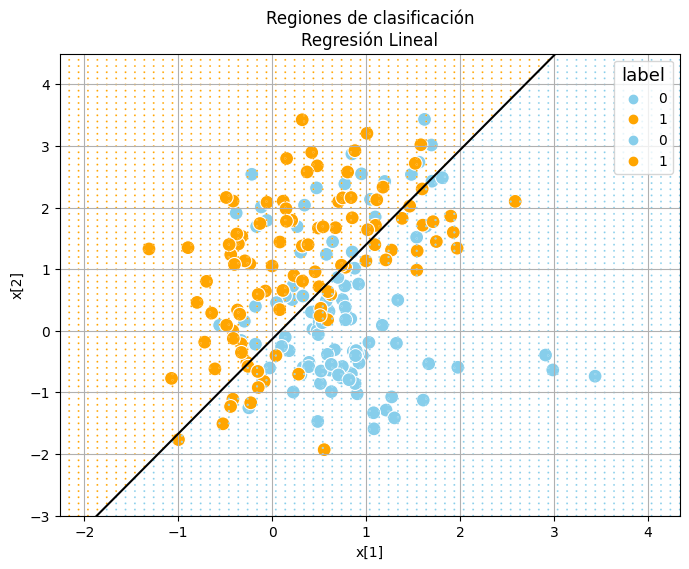

In [18]:
# Creamos el gráfico
plt.figure(figsize=(8, 6))

# Dibujamos los puntos de los datos
sns.scatterplot(data=data, x="x", y="y", hue="label", palette=palette, s=100)

# Dibujamos la línea de decisión del modelo
plt.plot(
    grilla["x"],
    (-coef_lm[0] * grilla["x"] + (0.5 - intercept_lm)) / coef_lm[1],
    color="black",
)

# Coloreamos los puntos de la grilla según su clase
sns.scatterplot(data=grilla, x="x", y="y", hue="clase", palette=palette, s=2)

# Configuramos las etiquetas y el título
plt.title("Regiones de clasificación\nRegresión Lineal")
plt.xlabel("x[1]")
plt.ylabel("x[2]")
plt.xlim(grilla["x"].min(), grilla["x"].max())
plt.ylim(grilla["y"].min(), grilla["y"].max())
plt.legend(title="label", title_fontsize="13", loc="best")
plt.grid(True)
plt.show()

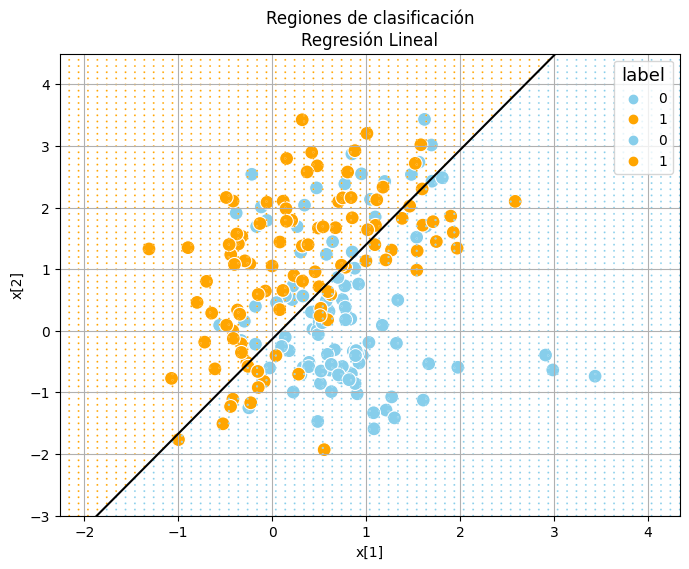

In [19]:
# Creamos el gráfico
plt.figure(figsize=(8, 6))

# Dibujamos los puntos de los datos
sns.scatterplot(data=data, x="x", y="y", hue="label", palette=palette, s=100)

# Dibujamos la línea de decisión del modelo
plt.plot(
    grilla["x"],
    (-lm_stat.params["x"] * grilla["x"] + (0.5 - lm_stat.params["Intercept"]))
    / lm_stat.params["y"],
    color="black",
)

# Coloreamos los puntos de la grilla según su clase
sns.scatterplot(data=grilla, x="x", y="y", hue="clase_stat", palette=palette, s=2)

# Configuramos las etiquetas y el título
plt.title("Regiones de clasificación\nRegresión Lineal")
plt.xlabel("x[1]")
plt.ylabel("x[2]")
plt.xlim(grilla["x"].min(), grilla["x"].max())
plt.ylim(grilla["y"].min(), grilla["y"].max())
plt.legend(title="label", title_fontsize="13", loc="best")
plt.grid(True)
plt.show()

### Vecinos cercanos con k = 25

In [20]:
from sklearn.neighbors import KNeighborsClassifier

# Ajustamos el modelo k-NN con k=25
knn_25 = KNeighborsClassifier(n_neighbors=25)
knn_25.fit(data[["x", "y"]], data["label"])

# Generamos predicciones para los datos de la grilla
model_knn_25 = knn_25.predict(grilla[["x", "y"]])

# Añadimos las predicciones al DataFrame de la grilla
grilla["label_k25"] = model_knn_25

# Generamos el DataFrame para el contorno
grilla_contour_k25 = grilla.copy()
grilla_contour_k25["z"] = model_knn_25

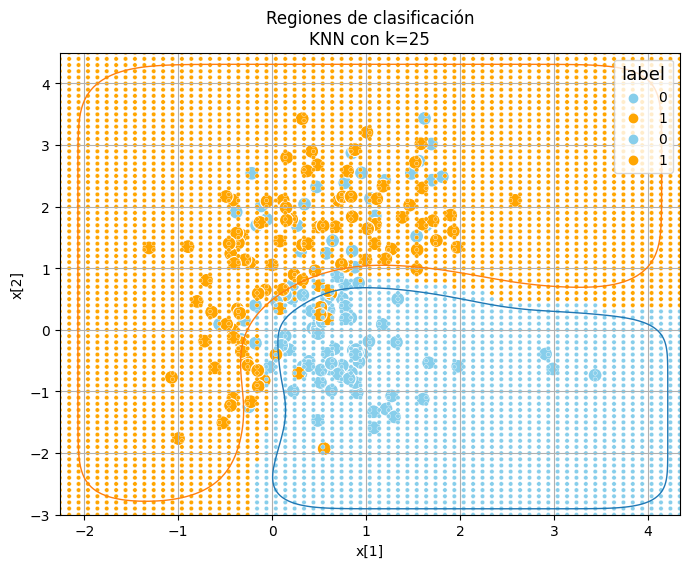

In [21]:
# Creamos el gráfico
plt.figure(figsize=(8, 6))

# Dibujamos los puntos de los datos
sns.scatterplot(data=data, x="x", y="y", hue="label", palette=palette, s=100)

# Coloreamos los puntos de la grilla según su clase
sns.scatterplot(data=grilla, x="x", y="y", hue="label_k25", palette=palette, s=10)

# Dibujamos el contorno de la región de decisión
sns.kdeplot(
    data=grilla_contour_k25,
    x="x",
    y="y",
    hue="z",
    levels=[0, 0.25],
    color="black",
    linewidths=1,
)

# Configuramos las etiquetas y el título
plt.title("Regiones de clasificación\nKNN con k=25")
plt.xlabel("x[1]")
plt.ylabel("x[2]")
plt.xlim(grilla["x"].min(), grilla["x"].max())
plt.ylim(grilla["y"].min(), grilla["y"].max())
plt.legend(title="label", title_fontsize="13", loc="best")
plt.grid(True)
plt.show()

### Vecinos cercanos con k = 1

In [22]:
from sklearn.neighbors import KNeighborsClassifier

# Ajustamos el modelo k-NN con k=25
knn_1 = KNeighborsClassifier(n_neighbors=1)
knn_1.fit(data[["x", "y"]], data["label"])

# Generamos predicciones para los datos de la grilla
model_knn_1 = knn_1.predict(grilla[["x", "y"]])

# Añadimos las predicciones al DataFrame de la grilla
grilla["label_k1"] = model_knn_1

# Generamos el DataFrame para el contorno
grilla_contour_k1 = grilla.copy()
grilla_contour_k1["z"] = model_knn_1

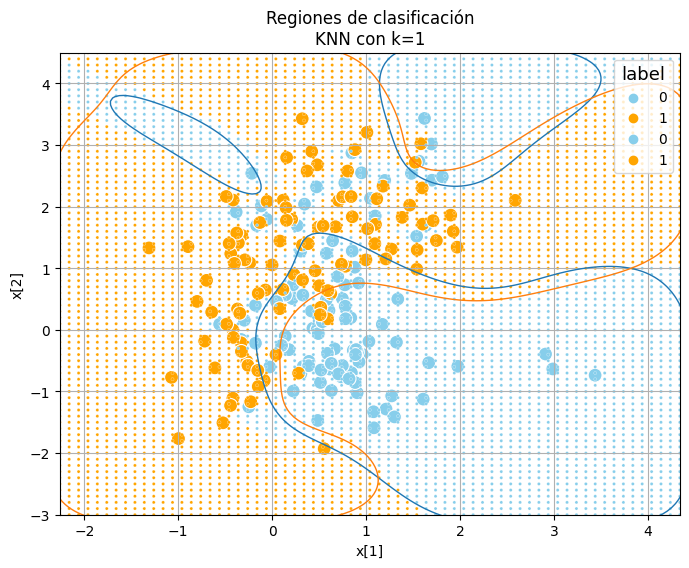

In [23]:
# Creamos el gráfico
plt.figure(figsize=(8, 6))

# Dibujamos los puntos de los datos
sns.scatterplot(data=data, x="x", y="y", hue="label", palette=palette, s=100)

# Coloreamos los puntos de la grilla según su clase
sns.scatterplot(data=grilla, x="x", y="y", hue="label_k1", palette=palette, s=5)

# Dibujamos el contorno de la región de decisión
sns.kdeplot(
    data=grilla_contour_k1,
    x="x",
    y="y",
    hue="z",
    levels=[0, 0.25],
    color="black",
    linewidths=1,
)

# Configuramos las etiquetas y el título
plt.title("Regiones de clasificación\nKNN con k=1")
plt.xlabel("x[1]")
plt.ylabel("x[2]")
plt.xlim(grilla["x"].min(), grilla["x"].max())
plt.ylim(grilla["y"].min(), grilla["y"].max())
plt.legend(title="label", title_fontsize="13", loc="best")
plt.grid(True)
plt.show()

### Regresion Logistica

In [24]:
from sklearn.linear_model import LogisticRegression

# Ajustamos el modelo de Regresión Logística
log_reg = LogisticRegression()
log_reg.fit(data[["x", "y"]], data["label"])

# Hacemos las predicciones para los datos de la grilla
log_reg_preds = log_reg.predict(grilla[["x", "y"]])

# Añadimos las predicciones al DataFrame de la grilla
grilla["label_logreg"] = log_reg_preds

# Creamos un DataFrame para el contorno
grilla_contour_logreg = grilla.copy()
grilla_contour_logreg["z"] = log_reg_preds

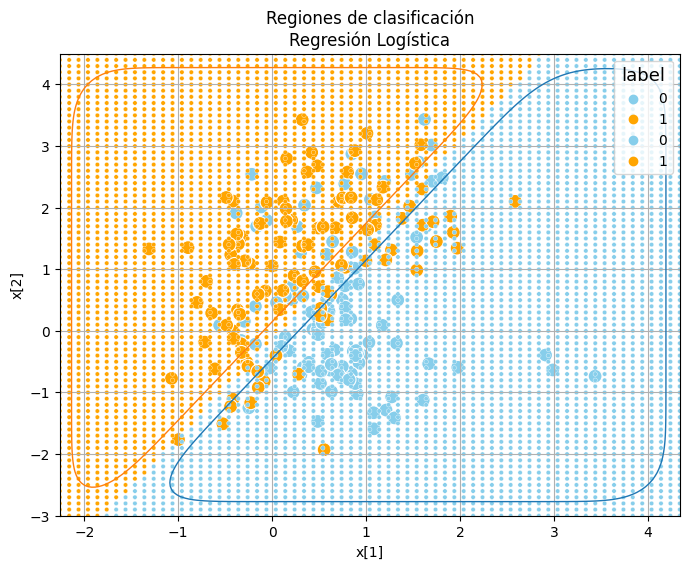

In [25]:
# Creamos el gráfico
plt.figure(figsize=(8, 6))

# Dibujamos los puntos de los datos
sns.scatterplot(data=data, x="x", y="y", hue="label", palette=palette, s=100)

# Coloreamos los puntos de la grilla según su clase
sns.scatterplot(data=grilla, x="x", y="y", hue="label_logreg", palette=palette, s=10)

# Dibujamos el contorno de la región de decisión
sns.kdeplot(
    data=grilla_contour_logreg,
    x="x",
    y="y",
    hue="z",
    levels=[0, 0.25],
    color="black",
    linewidths=1,
)

# Configuramos las etiquetas y el título
plt.title("Regiones de clasificación\nRegresión Logística")
plt.xlabel("x[1]")
plt.ylabel("x[2]")
plt.xlim(grilla["x"].min(), grilla["x"].max())
plt.ylim(grilla["y"].min(), grilla["y"].max())
plt.legend(title="label", title_fontsize="13", loc="best")
plt.grid(True)
plt.show()